## Problem 1.

$$
{\displaystyle {\begin{aligned}
D_{\text{KL}}(q_T\parallel p)&= \int q_T(x)\log\frac{q_T(x)}{p(x)}dx \\
&=\int q(y)T(x|y)\log\frac{q_T(x)}{p(x)}dxdy \\
&\le \int q(y)\log(\int\frac{T(x|y)q_T(x)}{p(x)}dx)dy \\
&= \int q(y)\log(\int\frac{T(y|x)q_T(x)}{p(y)}dx)dy \;\;\;\;\;\; \text{(detailed balance condition)}& \\
&= \int q(y)\log(\frac{q(y)\int T(y|x)q_T(x)dx}{q(y)p(y)})dy \\
&= D_{\text{KL}}(q \parallel p) + \int q(y)\log(\frac{\int T(y|x)q_T(x)dx}{q(y)})dy \\
&\le D_{\text{KL}}(q \parallel p) +  \log(\int T(y|x)q_T(x)dxdy) \\
&\le D_{\text{KL}}(q \parallel p) \\
\end{aligned}}}
$$

## Problem 2.

$\text{Ⅰ.} \;\mathcal{L}_K\le \log p(x)$
$$
{\displaystyle {\begin{aligned}
\mathcal{L}_K(q)&=  E_{\theta_1,...,\theta_k\text{~}q(\theta)}\log(\frac{1}{K}\sum_{i=1}^{K}\frac{p(x,\theta_i)}{q(\theta_i)})\\
&\le \log(\frac{1}{K}\sum_{i=1}^{K}\int\frac{p(x,\theta_i)}{q(\theta_i)}q(\theta_i)d\theta) \\
&=\log p(x) \\
\end{aligned}}}
$$
$\text{Ⅱ.} \;\mathcal{L}_K\ge \mathcal{L}_m \;\text{for}\; k\ge m, \;\text{(Burda et al., 2015)}$

$\text{Let I} \subset \{1,. . .,k\} \;\text{with |I| = m be a uniformly distributed subset of distinct indices from}\;\{1,...,k\}$ 
$$
{\begin{aligned}
\mathcal{L}_K(q)&=  E_{\theta_1,...,\theta_k\text{~}q(\theta)}\log(\frac{1}{K}\sum_{i=1}^{K}\frac{p(x,\theta_i)}{q(\theta_i)}) \\
&= E_{\theta_1,...,\theta_k\text{~}q(\theta)}\log E_{I=\{i_1,...,i_m\}}(\frac{1}{m}\sum_{j=1}^{m}\frac{p(x,\theta_{i_j})}{q(\theta_{i_j})}) \\
&\ge E_{\theta_1,...,\theta_k\text{~}q(\theta)}E_{I=\{i_1,...,i_m\}}\log(\frac{1}{m}\sum_{j=1}^{m}\frac{p(x,\theta_{i_j})}{q(\theta_{i_j})}) \\
&= E_{\theta_1,...,\theta_m\text{~}q(\theta)}\log(\frac{1}{m}\sum_{i=1}^{m}\frac{p(x,\theta_{i})}{q(\theta_{i})}) \\
&= \mathcal{L}_m(q)
\end{aligned}}
$$

## Problem 3.

### 3.（1）Derive the ELBO and gradient estimator (using the reparameterization trick) for a general normalizing flow model with a standard normal base distribution

### ELBO:

$$
{\displaystyle {\begin{aligned}
\mathcal{L}&=  \mathbb{E}_{q_k(z_k)}\log\frac{p(x, z_k)}{q_k(z_k)}\\
&= \mathbb{E}_{q_0(z_0)}\log p(x, z_k)-\mathbb{E}_{q_0(z_0)}\log q_0(z_0)-\sum_{k=1}^{K}\mathbb{E}_{q_0(z_0)}\log \bigg | det(\frac{\partial f_k(z_{k-1})}{\partial z_{k-1}}) \bigg | \;\;\;(reparameterization)\\
&z_0\text{~}N(0, 1), \;\;\; z_k = f_k\circ f_{k-1}\circ ... \circ f_{1}(z_0)=g(z_0)\\
\end{aligned}}}
$$

### Gradient estimator:

1. ELBO estimator:
$$
\mathcal{L} = \frac{1}{N}\sum_{i=1}^{N}\log p(x, g(z_{0,i}))-\frac{1}{N}\sum_{i=1}^{N}\log q_0(z_{0,i})-\sum_{k=1}^{K}\frac{1}{N}\sum_{i=1}^{N}\log \bigg | det(\frac{\partial f_k(z_{k-1,i})}{\partial z_{k-1}}) \bigg |
$$

2. Gradient estimator:
$$
\nabla\mathcal{L} = \frac{1}{N}\sum_{i=1}^{N}\nabla\log p(x, g(z_{0,i}))-\sum_{k=1}^{K}\frac{1}{N}\sum_{i=1}^{N}\nabla\log \bigg | det(\frac{\partial f_k(z_{k-1,i})}{\partial z_{k-1}}) \bigg |
$$

### 3.（2）Implement the following normalizing flows: planar flows, NICE and RealNVP.

In [44]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
from torch.nn import functional as F
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
from numpy.random import uniform,exponential,chisquare,normal,randint, shuffle
torch.manual_seed(2022)
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from matplotlib.pyplot import imshow
from torchvision.utils import make_grid

In [120]:
data = np.load('banana_shape_data.npy')

In [121]:
data.shape

(100,)

### planar flows

In [139]:
def log_joint_pdf(x, zk):
    sigma_y = torch.tensor(2)
    sigma_theta = torch.tensor(1)
    _t_ = torch.zeros(zk.shape[0]).to(device)
    for x_i in x:
        _t_ +=  - (x_i-zk[:,0]-zk[:,1]**2)**2/(2*sigma_y**2)
    return _t_ - (zk[:,0]**2+zk[:,1]**2)/(2*sigma_theta**2)

def ELBO(x, zk, log_jacobians):
    return (-log_jacobians - log_joint_pdf(x, zk)).mean()
    
class PlanarFlow(nn.Module):

    def __init__(self, data_dim=2):
        super().__init__()

        self.u = nn.Parameter(torch.rand(1, data_dim))
        self.w = nn.Parameter(torch.rand(1, data_dim))
        self.b = nn.Parameter(torch.rand(1))
        self.tanh = nn.Tanh()

    def forward(self, z):
        # transfrom
        activation = F.linear(z, self.w, self.b)
        x = z + self.u * self.tanh(activation)
        # log_det_jacobian
        psi = (1 - self.tanh(activation) ** 2) * self.w
        det_grad = 1 + torch.mm(psi, self.u.t())
        log_det_J = torch.log(det_grad + 1e-15)
        return x, log_det_J

class NormalizingFlowPlanar(nn.Module):

    def __init__(self, flow_length, data_dim=2):
        super().__init__()

        self.layers = nn.Sequential(
            *(PlanarFlow(data_dim) for _ in range(flow_length)))

    def forward(self, z):
        log_jacobians = 0
        for layer in self.layers:
            z, log_jacobian = layer(z)
            log_jacobians += log_jacobian
        return z, log_jacobians

In [142]:
def train(flow, optimizer, nb_epochs, batch_size, data_dim, data):
    training_loss = []

    for epoch in tqdm(range(nb_epochs)):
        z0 = torch.randn(batch_size, data_dim).to(device)
        zk, log_jacobian = flow(z0)

        # backward prop
        optimizer.zero_grad()
        loss = ELBO(data, zk, log_jacobian)  # negative ELBO
        loss.backward()
        optimizer.step()

        training_loss.append(loss.item())

    return training_loss

In [143]:
device = 'cpu'
flow_planar = NormalizingFlowPlanar(5).to(device)
optimizer = torch.optim.Adam(flow_planar.parameters(), lr=1e-2)
loss_planar = train(flow_planar, optimizer, 1000, 256, 2, data)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.31it/s]


In [148]:
def plot_ELBO(traces):
    loss = np.array(traces)
    elbo = -1*loss
    plt.plot(elbo, alpha=0.8)
    plt.xlabel("Epochs")
    plt.ylabel("ELBO")
    plt.show()

### NICE

In [130]:
class Coupling(nn.Module):
    def __init__(self, in_out_dim, mid_dim, hidden):
        super(Coupling, self).__init__()
        self.in_block = nn.Sequential(
            nn.Linear(in_out_dim//2, mid_dim),
            nn.ReLU())
        self.mid_block = nn.ModuleList([
            nn.Sequential(
                nn.Linear(mid_dim, mid_dim),
                nn.ReLU()) for _ in range(hidden - 1)])
        self.out_block = nn.Linear(mid_dim, in_out_dim//2)

    def forward(self, x, reverse=False):
        [B, W] = list(x.size())
        x = x.reshape((B, W//2, 2))
        off, on = x[:, :, 0], x[:, :, 1]
        off_ = self.in_block(off)
        for i in range(len(self.mid_block)):
            off_ = self.mid_block[i](off_)
        shift = self.out_block(off_)
        if reverse:
            on = on - shift
        else:
            on = on + shift
        x = torch.stack((on, off), dim=2)
        return x.reshape((B, W))

class Scaling(nn.Module):
    def __init__(self, dim):
        super(Scaling, self).__init__()
        self.scale = nn.Parameter(
            torch.zeros((1, dim)), requires_grad=True)

    def forward(self, x, reverse=False):
        log_det_J = torch.sum(self.scale)
        if reverse:
            x = x * torch.exp(-self.scale)
        else:
            x = x * torch.exp(self.scale)
        return x, log_det_J
    
    
class NormalizingFlowNICE(nn.Module):

    def __init__(self, coupling=3, in_out_dim=2, mid_dim=5, hidden=3):
        super(NormalizingFlowNICE, self).__init__()

        self.in_out_dim = in_out_dim

        self.coupling = nn.ModuleList([
            Coupling(in_out_dim=in_out_dim, 
                     mid_dim=mid_dim, 
                     hidden=hidden) \
            for i in range(coupling)])
        self.scaling = Scaling(in_out_dim)

    def forward(self, z):
        for i in range(len(self.coupling)):
            z = self.coupling[i](z)
        z, log_det_J = self.scaling(z)
        return z, log_det_J

In [131]:
device = 'cpu'; data_dim = 2;
flow_nice = NormalizingFlowNICE().to(device)
optimizer = torch.optim.Adam(flow_nice.parameters(), lr=1e-2)
loss_nice = train(flow_nice, optimizer, 1000, 256, data_dim, data)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 87.59it/s]


### RealNVP

In [126]:
class Scale(nn.Module):
    def __init__(self, in_out_dim, mid_dim, hidden):
        super(Scale, self).__init__()
        self.in_block = nn.Sequential(
            nn.Linear(in_out_dim//2, mid_dim),
            nn.ReLU())
        self.mid_block = nn.ModuleList([
            nn.Sequential(
                nn.Linear(mid_dim, mid_dim),
                nn.ReLU()) for _ in range(hidden - 1)])
        self.out_block = nn.Linear(mid_dim, in_out_dim//2)

    def forward(self, x, reverse=False):
        x = self.in_block(x)
        for i in range(len(self.mid_block)):
            off_ = self.mid_block[i](x)
        x = self.out_block(x)
        return x
    
class AffineCoupling(nn.Module):
    def __init__(self, in_out_dim=2, mid_dim=5, hidden=3):
        super(AffineCoupling, self).__init__()
        self.scale = Scale(in_out_dim=in_out_dim, mid_dim=mid_dim, hidden=hidden)
        self.translate = Scale(in_out_dim=in_out_dim, mid_dim=mid_dim, hidden=hidden)

    def forward(self, x):
        [B, W] = list(x.size())
        x = x.reshape((B, W//2, 2))
        off, on = x[:, :, 0], x[:, :, 1]
        # transform
        scale = self.scale(off)
        translate = self.translate(off)
        on = on*torch.exp(scale) + translate
        x = torch.stack((on, off), dim=2)
        # Jacobian
        log_det_J = scale.sum(-1)
        return x.reshape((B, W)), log_det_J
    
class RealNVP(nn.Module):

    def __init__(self, flow_length):
        super().__init__()

        self.layers = nn.Sequential(
            *(AffineCoupling() for _ in range(flow_length)))

    def forward(self, z):
        log_jacobians = 0
        for layer in self.layers:
            z, log_jacobian = layer(z)
            log_jacobians += log_jacobian
        return z, log_jacobians

In [127]:
device = 'cpu'; data_dim = 2;
flow_realnvp = RealNVP(5).to(device)
optimizer = torch.optim.Adam(flow_realnvp.parameters(), lr=1e-2)
loss_realnvp = train(flow_realnvp, optimizer, 1000, 256, data_dim, data)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 78.77it/s]


### Show the lower bound as a function of the number of iterations：

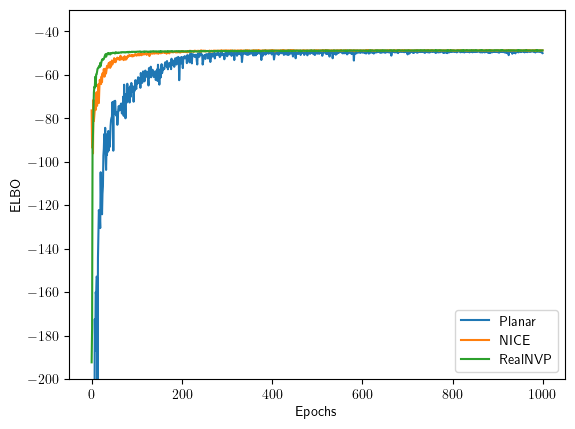

In [154]:
plt.plot(-np.array(loss_planar), label='Planar')
plt.plot(-np.array(loss_nice), label='NICE')
plt.plot(-np.array(loss_realnvp), label='RealNVP')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("ELBO")
plt.ylim(-200, -30)
plt.show()

### 3.（3） Implement a Hamiltonian Monte Carlo sampler

In [159]:
def U(x, theta):
    """
    U(x) = -logP(x)
    """
    sigma_y = np.array(2)
    sigma_theta = np.array(1)
    return np.sum((x - theta[0]-theta[1]**2)**2)/(2*sigma_y**2) + (theta[0]**2+theta[1]**2)/(2*sigma_theta**2)

def dU(x, theta):
    sigma_y = np.array(2)
    sigma_theta = np.array(1)
    dtheta1 = -np.sum((x - theta[0]-theta[1]**2))/(sigma_y**2) + theta[0]/(sigma_theta**2)
    dtheta2 = -np.sum((x - theta[0]-theta[1]**2))*2*theta[1]/(sigma_y**2) + theta[1]/(sigma_theta**2)
    return np.array((dtheta1, dtheta2))


def HMC(data, initial, Lmax, step_size, fixed= True, epochs=1000):
    """
    Hamiltonian Monte Carlo
    :param initial: 初始点
    :param Lmax: 每轮次步数
    :param step_size: 步长
    :param epochs: 轮次
    :return: 样本
    """
    samples = [initial]
    for epoch in tqdm(range(epochs)):
        r = normal(0, 1, 2)  # 每轮epoch重新生成动量
        x = samples[-1]  # 上一次到达的位置
        # 先保存这次起点的位置
        x_prev = np.copy(x)
        r_prev = np.copy(r)
        # Simulate Hamiltonian dynamics
        if fixed:
            L = Lmax
        else:
            L = randint(1, Lmax+1)
        for step in range(L):
            # Leap-frog积分
            r = r - 0.5 * step_size * dU(data, x)  # 加上势函数的负梯度
            x = x + step_size * r  # 这里取的质量都是1
            r = r - 0.5 * step_size * dU(data, x)
        # flip the sign of the momentum
        r = -r
        # 计算接受概率
        ratio = np.exp(-(U(data, x) + 0.5 * r @ r) + (U(data, x_prev) + 0.5 * r_prev @ r_prev))
        accept = 1 if 1 < ratio else ratio
        u = uniform(0, 1)
        if u <= accept:
            samples.append(x)
        else:
            samples.append(x_prev)
    return np.array(samples)

In [160]:
initial = np.array([1.0, 0.5])
hmc_trace = HMC(data, initial, Lmax = 30, step_size=0.05, fixed=True,epochs=20000)

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:14<00:00, 1341.81it/s]


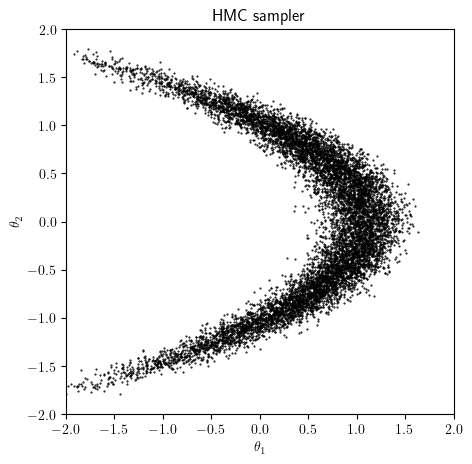

In [161]:
def scatter_2d(data):
    plt.figure(figsize=(5, 5))
    plt.scatter(data[10000:,0], data[10000:,1], marker='.', c = "black", s=1)
    # plt.legend()
    plt.xlabel(r"$ \theta_{1} $")
    plt.ylabel(r"$ \theta_{2} $")
    plt.title("HMC sampler")
    plt.ylim(-2, 2)
    plt.xlim(-2, 2)
    plt.show()
scatter_2d(hmc_trace)

### 3.（4）Show the scatter plots of these samples and compare to your HMC results.  Report the KL divergence to the ground truth

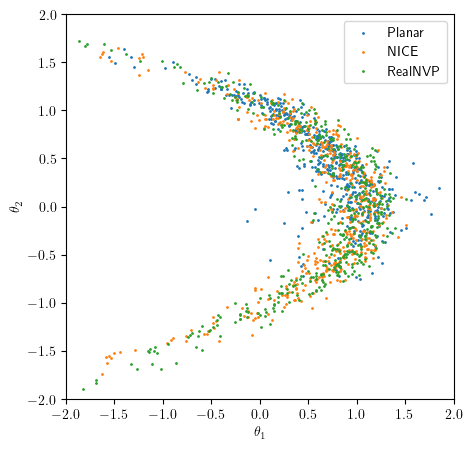

In [162]:
with torch.no_grad():
    z = torch.randn(500,2)
    zk_planar,_ = flow_planar(z.to(device))
    zk_nice,_ = flow_nice(z.to(device))
    zk_realnvp,_ = flow_realnvp(z.to(device))
plt.figure(figsize=(5, 5))
plt.scatter(zk_planar[:,0], zk_planar[:,1], label="Planar", s=1)
plt.scatter(zk_nice[:,0], zk_nice[:,1], label="NICE", s=1)
plt.scatter(zk_realnvp[:, 0], zk_realnvp[:, 1], label="RealNVP", s=1)
plt.legend()
plt.ylim(-2, 2)
plt.xlim(-2, 2)
plt.xlabel(r"$ \theta_{1} $")
plt.ylabel(r"$ \theta_{2} $")
plt.show()

In [156]:
import ite

In [157]:
co = ite.cost.BDKL_KnnK()

In [165]:
with torch.no_grad():
    z = torch.randn(10000,2)
    planar_trace ,_ = flow_planar(z.to(device))
    nice_trace ,_ = flow_nice(z.to(device))
    realnvp_trace,_ = flow_realnvp(z.to(device))

In [167]:
kl_planar = co.estimation(planar_trace, hmc_trace[10000:])
kl_nice = co.estimation(nice_trace, hmc_trace[10000:])
kl_realnvp = co.estimation(realnvp_trace, hmc_trace[10000:])
print("KL divergence of Planar:\t%.3f"%kl_planar)
print("KL divergence of NICE:\t\t%.3f"%kl_nice)
print("KL divergence of RealNVP:\t%.3f"%kl_realnvp)

KL divergence of Planar:	0.507
KL divergence of NICE:		0.055
KL divergence of RealNVP:	0.075


NICE和RealNVP的KL divergence相对Planar明显更低，他们的抽样结果（上图）都比较好

## Problem 4.

### 4.（1）Derive the evidence lower bound (ELBO) on the log likelihood of the model for N data points

$$
{\displaystyle {\begin{aligned}
\mathcal{L}(x;\theta,\phi)&=  \sum_{i=1}^{N}\mathbb{E}_{q_{\phi,i}}\log\frac{p_{\theta}(x_i, z_i)}{q_{\phi,i}(z_i|x_i)}\\
&= \sum_{i=1}^{N}\mathbb{E}_{q_{\phi,i}}\log p_{\theta}(x_i|z_i)+\log p(z_i)-\log q_{\phi,i}(z_i|x_i)\\
&= \sum_{i=1}^{N}\mathbb{E}_{q_{\phi,i}}\log p(x_i|z_i;\theta)\;(\text{reconstruction loss})-KL(q_{\phi,i}(z_i|x_i) || p(z_i))\\
&\text{where} \;\;KL(q_{\phi,i}(z_i|x_i) = \frac{1}{2}(1+\log(\sigma_i^2)-\mu_i^2-\sigma_i^2)\;\text{for gaussian prior}
\end{aligned}}}
$$

### 4.（2）Derive the gradient of the ELBO using the reparameterization trick. Briefly describe the advantages and disadvantages of VAE

1. Gradient with respect to $\theta$ ：

$$
{\displaystyle {\begin{aligned}
\nabla_{\theta}\mathcal{L}(x;\theta,\phi)&=  \nabla_{\theta}\sum_{i=1}^{N}\mathbb{E}_{q_{\phi,i}}\log\frac{p_{\theta}(x_i, z_i)}{q_{\phi,i}(z_i|x_i)}\\
&= \sum_{i=1}^{N}\mathbb{E}_{q_{\phi,i}}\nabla_{\theta}\log p_{\theta}(x_i, z_i)\\
&≈ \sum_{i=1}^{N}\frac{1}{K}\sum_{k=1}^{K}\nabla_{\theta}\log p_{\theta}(x_i, z_{i,k}) \;\;\;\;\;z_{i,k} \;\text{are samples from}\; q_{\phi,i}(z)\\
\end{aligned}}}
$$

2. Gradient with respect to $\phi$ ：

$$
{\displaystyle {\begin{aligned}
\nabla_{\phi}\mathcal{L}(x;\theta,\phi)&=  \nabla_{\phi}\sum_{i=1}^{N}\mathbb{E}_{q_{\phi,i}}\log\frac{p_{\theta}(x_i, z_i)}{q_{\phi,i}(z_i|x_i)}\\
&=  \sum_{i=1}^{N}\mathbb{E}_{q_{\epsilon}}\;(\nabla_{\phi}\log p_{\theta}(x_i, g_{\phi,i}(\epsilon))-\nabla_{\phi}\log q_{\phi,i}(g_{\phi,i}(\epsilon))\;)\\
&=  \sum_{i=1}^{N}\frac{1}{K}\sum_{k=1}^{K}\;(\nabla_{\phi}\log p_{\theta}(x_i, g_{\phi,i}(\epsilon_k))-\nabla_{\phi}\log q_{\phi,i}(g_{\phi,i}(\epsilon_k))\;) \;\;\;\epsilon_k\;\text{are samples from}\;q_{\epsilon}(\epsilon_k)\\
\end{aligned}}}
$$

3. (reparameterization) transformation from $\epsilon$ to z:
$$
z_i = \mu+\sigma\epsilon,\;\;\epsilon\sim \mathcal{N}(0,1)\\
\mu,\sigma=f_{\lambda}(x_i) \;\;\; f_{\lambda}\;\text{is a neural network with parameter}\;\lambda
$$

4. advantages and disadvantages:
- VAE的优点在于其隐变量空间是连续的，方便生成新的样本（相对于普通Autoencoder而言）
- ELBO相对于GAN来讲可能更方便训练（收敛性）
- VAE的不足是对z采样重建过程中引入了采样噪声，重建的图形比较模糊

### 4.（3）Implement and train this VAE model for about 100 epochs.

In [60]:
class VAE(nn.Module):
    def __init__(self, input_dim = 28*28, enc_out_dim=512, latent_dim = 2):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, enc_out_dim), 
            nn.ReLU()
        )

        self.decoder =  nn.Sequential(
            nn.Linear(latent_dim, enc_out_dim),
            nn.ReLU(),
            nn.Linear(enc_out_dim, input_dim)
        ) 
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))
        
    def log_pxz(self, x_hat, logscale, x):
        scale = torch.exp(logscale)
        mean = x_hat
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(x)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # p(z): normal prior
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        # p(z|x)
        q = torch.distributions.Normal(mu, std)
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)
        # sum of samples (apply mean to get KL)
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl
    
    def forward(self, x):
        # encoder
        x_encoded = self.encoder(self.flatten(x))
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)
        # sample z from p(z|x)
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()
        # decoder
        x_hat = self.decoder(z).reshape((-1, 1, 28, 28))
        # compute ELBO loss
        # reconstruction loss
        recon_loss = self.log_pxz(x_hat, self.log_scale, x)
        # kl divergence to prior
        kl = self.kl_divergence(z, mu, std)
        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()
        return z, x_hat, elbo

In [16]:
training_data = datasets.MNIST(
    root=".",
    train=True,
    download=False,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root=".",
    train=False,
    download=False,
    transform=ToTensor()
)

In [77]:
train_dataloader = DataLoader(training_data, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=True)

In [75]:
def train(dataloader, model, optimizer, epochs = 100):
    size = len(dataloader.dataset)
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        for batch, (X, y) in enumerate(dataloader):
            X = X.to(device) # GPU
            _, X_hat, loss = model(X)
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if batch % 100 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [78]:
device = 'cuda'
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train(train_dataloader, model, optimizer, epochs = 100)

Epoch 1
-------------------------------
loss: 797.645508  [    0/60000]
loss: 670.788757  [12800/60000]
loss: 596.671082  [25600/60000]
loss: 522.780029  [38400/60000]
loss: 452.520691  [51200/60000]
Epoch 2
-------------------------------
loss: 409.677704  [    0/60000]
loss: 343.998840  [12800/60000]
loss: 276.591248  [25600/60000]
loss: 223.204987  [38400/60000]
loss: 164.929581  [51200/60000]
Epoch 3
-------------------------------
loss: 125.745605  [    0/60000]
loss: 79.033493  [12800/60000]
loss: 32.137486  [25600/60000]
loss: 6.542578  [38400/60000]
loss: -30.562204  [51200/60000]
Epoch 4
-------------------------------
loss: -47.672741  [    0/60000]
loss: -68.853745  [12800/60000]
loss: -89.564049  [25600/60000]
loss: -82.243881  [38400/60000]
loss: -105.268539  [51200/60000]
Epoch 5
-------------------------------
loss: -103.101562  [    0/60000]
loss: -102.301567  [12800/60000]
loss: -115.144928  [25600/60000]
loss: -123.652405  [38400/60000]
loss: -138.789917  [51200/60000

Epoch 41
-------------------------------
loss: -159.040588  [    0/60000]
loss: -202.542404  [12800/60000]
loss: -179.407867  [25600/60000]
loss: -163.983749  [38400/60000]
loss: -180.810883  [51200/60000]
Epoch 42
-------------------------------
loss: -176.303894  [    0/60000]
loss: -195.817902  [12800/60000]
loss: -172.309784  [25600/60000]
loss: -169.017975  [38400/60000]
loss: -173.386017  [51200/60000]
Epoch 43
-------------------------------
loss: -206.507446  [    0/60000]
loss: -180.665131  [12800/60000]
loss: -196.391953  [25600/60000]
loss: -170.046234  [38400/60000]
loss: -193.916931  [51200/60000]
Epoch 44
-------------------------------
loss: -183.126602  [    0/60000]
loss: -156.740768  [12800/60000]
loss: -165.868698  [25600/60000]
loss: -181.140350  [38400/60000]
loss: -171.533051  [51200/60000]
Epoch 45
-------------------------------
loss: -176.490723  [    0/60000]
loss: -177.854431  [12800/60000]
loss: -189.711670  [25600/60000]
loss: -165.840912  [38400/60000]
los

loss: -175.898438  [51200/60000]
Epoch 81
-------------------------------
loss: -159.292236  [    0/60000]
loss: -210.564484  [12800/60000]
loss: -172.628235  [25600/60000]
loss: -182.317413  [38400/60000]
loss: -173.958679  [51200/60000]
Epoch 82
-------------------------------
loss: -154.220764  [    0/60000]
loss: -206.284927  [12800/60000]
loss: -178.370132  [25600/60000]
loss: -174.514816  [38400/60000]
loss: -200.184738  [51200/60000]
Epoch 83
-------------------------------
loss: -226.543686  [    0/60000]
loss: -171.722931  [12800/60000]
loss: -198.349274  [25600/60000]
loss: -186.965454  [38400/60000]
loss: -156.070953  [51200/60000]
Epoch 84
-------------------------------
loss: -182.664993  [    0/60000]
loss: -185.576904  [12800/60000]
loss: -186.279877  [25600/60000]
loss: -220.896439  [38400/60000]
loss: -179.244385  [51200/60000]
Epoch 85
-------------------------------
loss: -180.698547  [    0/60000]
loss: -202.181931  [12800/60000]
loss: -157.181747  [25600/60000]
los

### 4.（4）Visualize a random sample of 100 MNIST digits on 10 × 10 tile grid.

In [87]:
def img_sampler(model, num_preds = 16):
    rand_v = torch.rand((num_preds, 2))
    p = torch.distributions.Normal(torch.zeros_like(rand_v), torch.ones_like(rand_v))
    z = p.rsample().to(device)
    with torch.no_grad():
        pred = model.decoder(z).reshape((-1, 1, 28, 28))
    img = make_grid(pred, nrow=10).permute(1, 2, 0).cpu().numpy()  
    plt.figure(figsize=(8, 8))
    imshow(img, cmap="gray");

###  “fake” digits

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


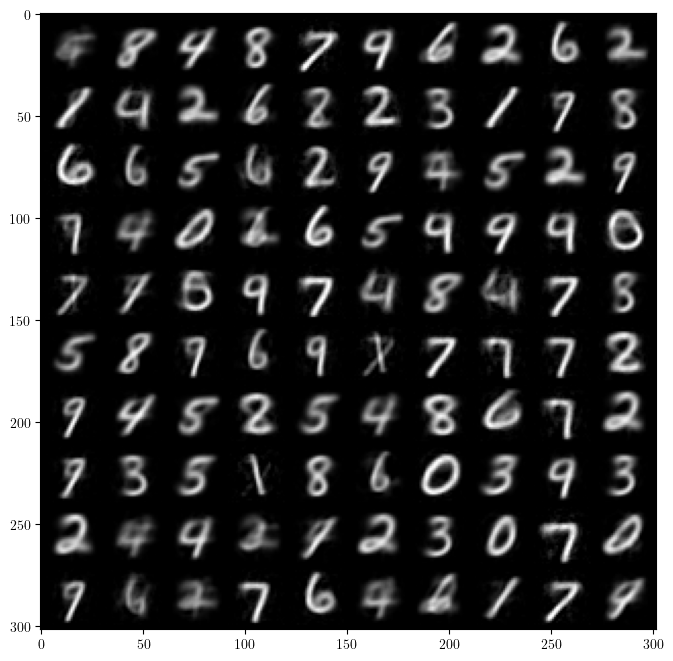

In [88]:
img_sampler(model, num_preds = 100)

### 4.（5）Visualize the points in the latent space as a scatter plot, where colors of points should correspond to the labels of the digits

In [85]:
def plot_latent(model, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        with torch.no_grad():
            x = x.to(device)
            z, _, _ = model(x)
            z = z.to('cpu').detach().numpy()
            plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10', s=3)
            if i > num_batches:
                plt.colorbar()
                break

### latent space

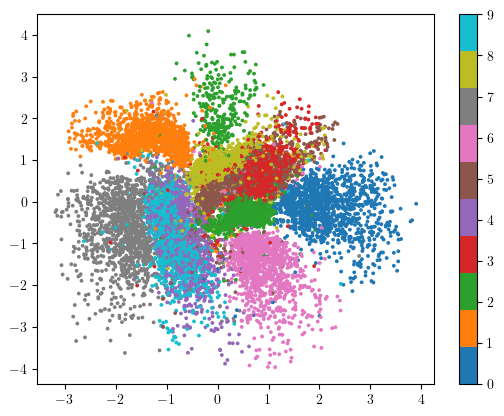

In [86]:
plot_latent(model, train_dataloader, num_batches=100)

In [118]:
def plot_reconstructed(model):
    # 假设z1和z2的范围都是[-3, 3]
    x = torch.linspace(-3, 3, 20)
    y = torch.linspace(3, -3, 20)
    grid = torch.zeros((20*20, 2))
    # row by row
    for idy, i in enumerate(y):
        for idx, j in enumerate(x):
            grid[idy*20+idx, :] = torch.tensor((j, i))
    z = grid.to(device)
    with torch.no_grad():
        pred = model.decoder(z).reshape((-1, 1, 28, 28))
    img = make_grid(pred, nrow=20).permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(8, 8))
    imshow(img, cmap="gray");

### traversing latent space

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


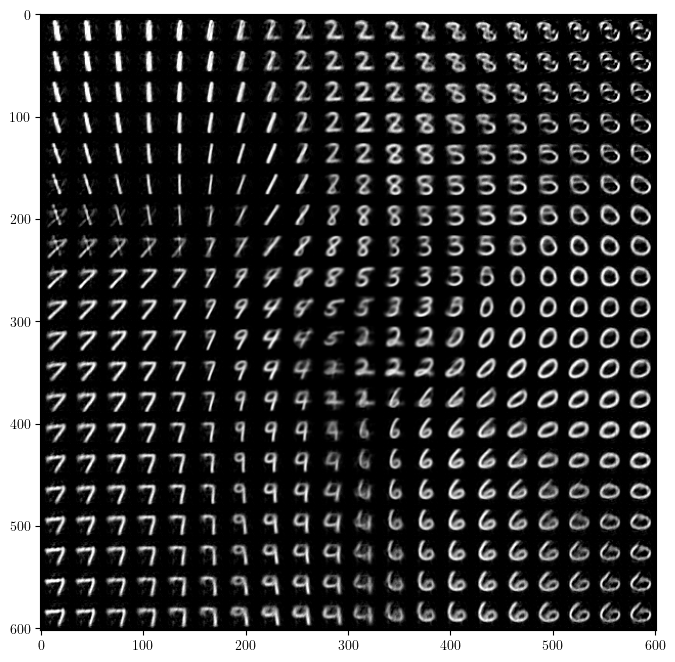

In [119]:
plot_reconstructed(model)